In [218]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
#import pandas_gbp
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

def fetch_covid19_cases(table):
    # Construct a BigQuery client object.
    client = bigquery.Client()
    query = """
        SELECT *, 
        FROM `bigquery-public-data.covid19_jhu_csse.{0}`
    """.format(table)
    df_confirmed_cases = client.query(query).to_dataframe()
    df_confirmed_cases.drop(['latitude', 'longitude', 'location_geom'], axis=1, inplace=True)
    df_confirmed_cases['province_state'] = df_confirmed_cases['province_state'].fillna('ALL')
    df_confirmed_cases = df_confirmed_cases[df_confirmed_cases['province_state'] == 'ALL']
    df_confirmed_cases.rename(columns={'country_region': 'country'}, inplace=True)
    #df_confirmed_cases = df_confirmed_cases.set_index('country')
    df_confirmed_cases.drop(['province_state'], axis=1, inplace=True)
    return df_confirmed_cases

def fetch_population():
    client = bigquery.Client()
    query = """
        SELECT country_code, country_name as country, midyear_population as population FROM `bigquery-public-data.census_bureau_international.midyear_population`
        where year = EXTRACT(year from (CURRENT_DATE()))
        order by midyear_population desc
    """
    df_world_population = client.query(query).to_dataframe()
    df_world_population['country'][df_world_population['country'] == 'United States'] = 'US'
    df_world_population = df_world_population.set_index('country')
    return df_world_population

def covid_flip_datetocolumn(df_covid, col_name):
    dates = df_covid.columns[1:]
    df_temp = df_covid.melt(
        id_vars=['country'], 
        value_vars=dates,
        var_name='date', 
        value_name=col_name
    )
    df_temp['date']=df_temp['date'].map(lambda strtodate: strtodate.replace('_','/')[1:])
    return df_temp

# Calculates ratio of two countries numbes either confirmed cases, deaths, recovered
def covid_ratio_by_country(df_covid_popl, col_name, source, dest):
    df_top = df_covid_popl[[col_name, 'date']][df_covid_popl['country'] == source] 
    df_down = df_covid_popl[[col_name, 'date']][df_covid_popl['country'] == dest] 
    df_ratio = df_top.merge(df_down, on='date')
    df_ratio['ratio'] = df_ratio[col_name + '_x'] / df_ratio[col_name + '_y'] 
    return df_ratio[['date', 'ratio']]

# Plots ratios calculated above, need to change this to pass column names
def covid_plot_ratio(df):
    fig, ax = plt.subplots()
    ax.plot(df['date'], df['ratio'], label=country)
    #ax.set_xlim(0, 200) - doesnt work with dates
    ax.set_ylim(0, 8)
    ax.xaxis.set_major_locator(MultipleLocator(30))
    ax.xaxis.set_minor_locator(AutoMinorLocator(7))
    ax.grid(which='major', color='#CCCCCC', linestyle='--')
    ax.grid(which='minor', color='#CCCCCC', linestyle=':')
    ax.legend()
    plt.show()

In [219]:
# Fetch all the necessary data from bigquery
df_confirmed = fetch_covid19_cases('confirmed_cases')
df_deaths = fetch_covid19_cases('deaths')
df_recovered = fetch_covid19_cases('recovered_cases')
df_world_population = fetch_population()
# Fetch exchange rate
df_exchange_rates = pd.read_csv('exchangerates.csv', delimiter = ',')
df_exchange_rates['date'] = df_exchange_rates['date'].map(lambda x: datetime.strptime(x, "%d/%m/%Y"))

In [220]:
#Preprocess
#remove canada as per https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6
df_recovered = df_recovered[df_recovered['country']!='Canada']
df_covid = covid_flip_datetocolumn(df_confirmed, 'confirmed').merge(
    right=covid_flip_datetocolumn(df_deaths, 'deaths'), 
    how='left',
    on=['country', 'date']
).merge(
    right=covid_flip_datetocolumn(df_recovered, 'recovered'),
    how='left',
    on=['country', 'date']
)
#remove ship data  https://towardsdatascience.com/covid-19-data-processing-58aaa3663f6
ship_rows = df_covid['country'].str.contains('Diamond Princess') | df_covid['country'].str.contains('MS Zaandam')
df_covid = df_covid[~(ship_rows)]

df_covid['active'] = df_covid['confirmed'] - df_covid['deaths'] - df_covid['recovered']
df_covid_popl = df_covid.join(df_world_population, how='outer', on='country')
for var in ['confirmed', 'deaths', 'recovered', 'active']:
    df_covid_popl[var + '_per1m'] = df_covid_popl[var] * 1000000 / df_covid_popl['population']
df_covid['date'] = df_covid['date'].map(lambda x: datetime.strptime(x, "%m/%d/%y"))

df_covid_popl.dropna(subset=['date'], inplace=True)
df_covid_popl['date'] = df_covid_popl['date'].map(lambda x: datetime.strptime(x, "%m/%d/%y"))
df_covid_popl = df_covid_popl[df_covid_popl['date'] > np.datetime64('2020-03-01T00:00:00-08')]

In [221]:
df_covid_popl[(df_covid_popl['country'] == 'United Kingdom') & (df_covid_popl['date'] > np.datetime64('2020-05-01T00:00:00-08'))]

,country,date,confirmed,deaths,recovered,active,country_code,population,confirmed_per1m,deaths_per1m,recovered_per1m,active_per1m
18856.0,United Kingdom,2020-05-02,182260.0,28131.0,0.0,154129.0,UK,65761117.0,2771.546596,427.775581,0.0,2343.771016
19041.0,United Kingdom,2020-05-03,186599.0,28446.0,0.0,158153.0,UK,65761117.0,2837.527836,432.565645,0.0,2404.962191
19226.0,United Kingdom,2020-05-04,190584.0,28734.0,0.0,161850.0,UK,65761117.0,2898.125955,436.945133,0.0,2461.180822
19411.0,United Kingdom,2020-05-05,194990.0,29427.0,0.0,165563.0,UK,65761117.0,2965.126033,447.483275,0.0,2517.642758
19596.0,United Kingdom,2020-05-06,201101.0,30076.0,0.0,171025.0,UK,65761117.0,3058.053287,457.352329,0.0,2600.700958
19781.0,United Kingdom,2020-05-07,206715.0,30615.0,0.0,176100.0,UK,65761117.0,3143.422883,465.548662,0.0,2677.874222
19966.0,United Kingdom,2020-05-08,211364.0,31241.0,0.0,180123.0,UK,65761117.0,3214.118154,475.067965,0.0,2739.050190
20151.0,United Kingdom,2020-05-09,215260.0,31587.0,0.0,183673.0,UK,65761117.0,3273.362890,480.329432,0.0,2793.033458
20336.0,United Kingdom,2020-05-10,219183.0,31855.0,0.0,187328.0,UK,65761117.0,3333.018203,484.404789,0.0,2848.613414
20521.0,United Kingdom,2020-05-11,223060.0,32065.0,0.0,190995.0,UK,65761117.0,3391.974014,487.598165,0.0,2904.375849


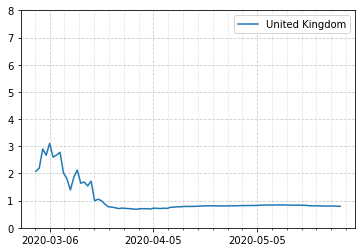

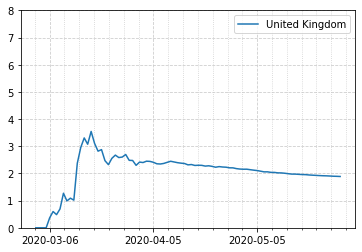

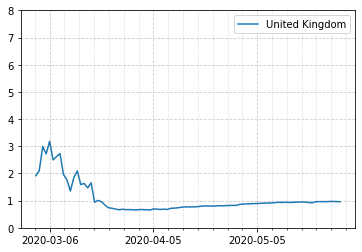

In [222]:
df_ratio = covid_ratio_by_country(df_covid_popl, 'confirmed_per1m', 'United Kingdom', 'US')
covid_plot_ratio(df_ratio)
df_ratio = covid_ratio_by_country(df_covid_popl, 'deaths_per1m', 'United Kingdom', 'US')
covid_plot_ratio(df_ratio)
df_ratio = covid_ratio_by_country(df_covid_popl, 'active_per1m', 'United Kingdom', 'US')
covid_plot_ratio(df_ratio)



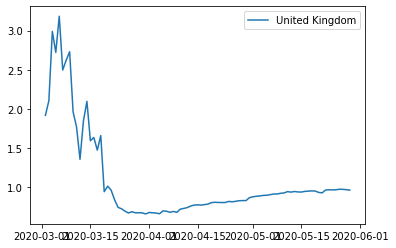

In [217]:
df = df_ratio
fig, ax = plt.subplots()
ax.plot(df['date'], df['ratio'], label=country)
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
for country in ['US', 'United Kingdom', 'Italy', 'India']:
    ax.plot(df_covid_popl['date'][df_covid_popl['country'] == country], df_covid_popl['confirmed'][df_covid_popl['country'] == country], label=country)
ax.legend()
plt.show()

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots()
for country in ['US', 'United Kingdom', 'Italy', 'India']:
    ax.plot(df_covid_popl['date'][df_covid_popl['country'] == country], df_covid_popl['confirmed_per1m'][df_covid_popl['country'] == country], label=country)
ax.set_xlim(0, 200)
ax.set_ylim(0, 8)
ax.xaxis.set_major_locator(MultipleLocator(30))
ax.xaxis.set_minor_locator(AutoMinorLocator(7))
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')
ax.legend()
plt.show()

fig, ax = plt.subplots()
for country in ['US', 'United Kingdom', 'Italy', 'India']:
    ax.plot(df_covid_popl['date'][df_covid_popl['country'] == country], df_covid_popl['deaths_per1m'][df_covid_popl['country'] == country], label=country)
ax.legend()
plt.show()

fig, ax = plt.subplots()
for country in ['US', 'United Kingdom', 'Italy', 'India']:
    ax.plot(df_covid_popl['date'][df_covid_popl['country'] == country], df_covid_popl['active_per1m'][df_covid_popl['country'] == country], label=country)
ax.legend()
plt.show()